# Policy iteration and value iteration

In this notebook, you will implement different dynamic programming approaches described in [Sutton and Barto's book, Introduction to Reinforcement Learning](http://incompleteideas.net/book/the-book-2nd.html). A grid ```World``` class and policy iteration has been implemented. Feel free to add more actions, rewards and/or terminals, or to modify the code to suit your needs.

### Install dependencies

In [32]:
! pip install numpy pandas

! pip install PyQt6

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


### Imports

In [33]:
import numpy as np
import sys          # We use sys to get the max value of a float
import pandas as pd # We only use pandas for displaying tables nicely
pd.options.display.float_format = '{:,.3f}'.format
import matplotlib.pyplot as plt
import time
import os

### ```World``` class and globals

The ```World``` is a grid represented as a two-dimensional array of characters where each character can represent free space, an obstacle, or a terminal. Each non-obstacle cell is associated with a reward that an agent gets for moving to that cell (can be 0). The size of the world is _width_ $\times$ _height_ characters.

A _state_ is a tuple $(x,y)$.

An empty world is created in the ```__init__``` method. Obstacles, rewards and terminals can then be added with ```add_obstacle``` and ```add_reward```.

To calculate the next state of an agent (that is, an agent is in some state $s = (x,y)$ and performs and action, $a$), ```get_next_state()```should be called. It will only be relevant to call this function later on, when we do learning based on interaction with the environment and where an agent actually has to move.

For now, you will only need the probabilities over next states given an action, $a$, that is, call ```get_state_transition_probabilities```.

In [ ]:

# Globals:
ACTIONS = ("up", "down", "left", "right")

# Rewards, terminals and obstacles are characters:
REWARDS = {" ": 0, ".": 0.1, "+": 10, "-": -10}
TERMINALS = ("+", "-") # Note a terminal should also have a reward assigned
OBSTACLES = ("#")

# Discount factor
gamma = 1

# The probability of a random move:
rand_move_probability = 0

#Tempreture parameter (for Boltzmann policy) [high beta is greedy low is exploration]
beta = 0.1

#numbers of drones to simulate
number_of_agents = 10


class World:
  def __init__(self, width, height):
    self.width = width
    self.height = height
    # Create an empty world where the agent can move to all cells
    self.grid = np.full((width, height), ' ', dtype='U1')

  def add_obstacle(self, start_x, start_y, end_x=None, end_y=None):
    """
    Create an obstacle in either a single cell or rectangle.
    """
    if end_x == None: end_x = start_x
    if end_y == None: end_y = start_y

    self.grid[start_x:end_x + 1, start_y:end_y + 1] = OBSTACLES[0]

  def add_reward(self, x, y, reward):
    assert reward in REWARDS, f"{reward} not in {REWARDS}"
    self.grid[x, y] = reward

  def add_terminal(self, x, y, terminal):
    assert terminal in TERMINALS, f"{terminal} not in {TERMINALS}"
    self.grid[x, y] = terminal

  def is_obstacle(self, x, y):
    if x < 0 or x >= self.width or y < 0 or y >= self.height:
      return True
    else:
      return self.grid[x ,y] in OBSTACLES

  def is_terminal(self, x, y):
    return self.grid[x ,y] in TERMINALS

  def get_reward(self, x, y):
    """
    Return the reward associated with a given location
    """
    return REWARDS[self.grid[x, y]]

  def get_next_state(self, current_state, action, deterministic=False):
    """
    Get the next state given a current state and an action. Can eiter be
    deterministic (no random actions) or non-deterministic,
    where rand_move_probability determines the probability of ignoring the
    action and performing a random move.
    """
    assert action in ACTIONS, f"Unknown acion {action} must be one of {ACTIONS}"

    x, y = current_state

    # If our current state is a terminal, there is no next state
    if self.grid[x, y] in TERMINALS:
      return None

    # Check of a random action should be performed:
    if not deterministic and np.random.rand() < rand_move_probability:
      action = np.random.choice(ACTIONS)

    if action == "up":      y -= 1
    elif action == "down":  y += 1
    elif action == "left":  x -= 1
    elif action == "right": x += 1

    # If the next state is an obstacle, stay in the current state
    return (x, y) if not self.is_obstacle(x, y) else current_state

  def get_state_transition_probabilities(self, current_state, action):
    """
    Returns a dict where key = state and value = probability given current state
    is (x,y) and "action" is performed.
    """
    assert action in ACTIONS, f"Unknown acion {action} must be one of {ACTIONS}"

    x, y = current_state
    if self.is_terminal(x, y):
      return {}

    next_state_probabilities = {}
    # Since there is rand_move_probability of performing any action, we have to
    # go through all actions and check what their next state would be:
    for a in ACTIONS:
      next_state = self.get_next_state((x, y), a, deterministic=True)
      if a == action:
        prob = 1 - rand_move_probability + rand_move_probability / len(ACTIONS)
      else:
        prob = rand_move_probability / len(ACTIONS)

      if next_state in next_state_probabilities:
        next_state_probabilities[next_state] += prob
      else:
        if prob > 0.0:
          next_state_probabilities[next_state] = prob

    return next_state_probabilities

# Drone class


In [ ]:
import numpy as np

class Drone:
    def __init__(self, drone_id, world, start_position=None, q_table_file="q_table.npy"):
        self.id = drone_id
        self.world = world
        self.q_table_file = q_table_file
        self.Q = self.load_or_initialize_q_table()
        self.position = start_position if start_position else (np.random.randint(0, world.width), np.random.randint(0, world.height))
        
        # Ensure starting position is not an obstacle
        while self.world.is_obstacle(*self.position):
            self.position = (np.random.randint(0, world.width), np.random.randint(0, world.height))
        
        self.cumulative_reward = 0  # Track total collected rewards
        self.visited_positions = [self.position]  # Track visited positions
        self.active = True  # Drone status
    
    def compute_reward(self, position):
        """ Compute the reward for moving to a new position """
        for drone in number_of_agents:
            
        return self.world.get_reward(*position)
    
    def softmax_policy(self, available_actions):
        """ Select an action using softmax over rewards """
        q_values = np.array([self.compute_reward(pos) for pos in available_actions])
        exp_q = np.exp(q_values)
        probabilities = exp_q / np.sum(exp_q)
        return available_actions[np.random.choice(len(available_actions), p=probabilities)]
    
    def load_or_initialize_q_table(self):
        """ Check if Q-table file exists, load it, otherwise initialize a new Q-table. """
        if os.path.exists(self.q_table_file):
            return np.load(self.q_table_file)
        else:
            return np.random.rand(self.world.width, self.world.height, len(ACTIONS))
    
    def update_position(self):
        """ Move based on softmax action selection """
        if not self.active or self.world.is_terminal(*self.position):
            return
        
        search_directions = {
            "up": (self.position[0], self.position[1] - 1),
            "down": (self.position[0], self.position[1] + 1),
            "left": (self.position[0] - 1, self.position[1]),
            "right": (self.position[0] + 1, self.position[1])
        }
        
        available_actions = [pos for action, pos in search_directions.items()
                             if not self.world.is_obstacle(*pos) and 0 <= pos[0] < self.world.width and 0 <= pos[1] < self.world.height]
        
        if available_actions:
            best_move = self.softmax_policy(available_actions)
            self.position = best_move
            self.cumulative_reward += self.compute_reward(best_move)
        
        self.visited_positions.append(self.position)
        
        if self.world.is_terminal(*self.position):
            self.active = False


# Policy og action selection

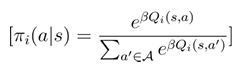 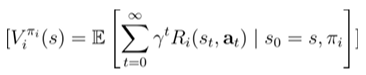 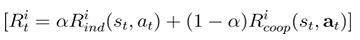

In [ ]:
# Global variable to keep track of current estimates
Q = np.random.rand(world.width, world.height, len(ACTIONS))

# Define a function for the Boltzmann policy
def swarmdrone_policy(x, y, Q, beta=1.0):
    # Get Q-values for all actions at state (x, y)
    q_values = Q[x, y, :]

    # Compute the exponentiated values
    exp_q = np.exp(beta * q_values)

    # Normalize to get probabilities
    probabilities = exp_q / np.sum(exp_q)

    # Return a dictionary mapping actions to their probabilities
    return {action: prob for action, prob in zip(ACTIONS, probabilities)}



## Basic examples: World, obstacles, rewards and terminals

Below are some examples to illustrate how the ```World``` class works.

First, we create a 4x4 world:

In [37]:
world = World(4, 4)

# Note, that we have to transpose the 2D array (.T) for (x,y)
# to match the convention when displayed
print(world.grid.T)

[[' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]


Obstacles and terminals are all represented as single characters:

In [38]:
print(f"Obstacles: {OBSTACLES}")
print(f"Terminals: {TERMINALS}")

Obstacles: #
Terminals: ('+', '-')


Rewards are also represented as characters in the world, but they have an associated value (note that defining a value for an empty space "  " is equivalent to the agent receiving that reward each time a move is made):

In [39]:
print(f"Rewards: {REWARDS}")

Rewards: {' ': 0, '.': 0.1, '+': 10, '-': -10}


To assign rewards to terminal states, just use the same character in the ```REWARDS``` dict and in the ```TERMINALS``` tuple.

In [40]:
for t in TERMINALS:
  print(f"Terminal {t} has reward {REWARDS[t]}")

world.add_terminal(0, 0, "+")
world.add_terminal(3, 3, "-")


print(world.grid.T)

# An alternative way of displaying the world using pandas:


Terminal + has reward 10
Terminal - has reward -10
[['+' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' '-']]


## Policies ($\pi$)

Recall that a policy, $\pi(a|s) = \Pr(A_t = a | S_t = s)$, maps states to action probabilities. In the code below, we let policies return the probabilities of each possible action given a state. States are $(x, y)$ coordinates and the policy must return action probabilities as a dict where the action is the ```key``` and the corresponding ```value``` is the probability of taking that action in the given state. Deterministic policies, for instance, return a dict with only one entry (e.g. ```{ "up": 1 } ``` if the action for the current state is ```up```).

A random policy can be defined as follows:


In [41]:
def equiprobable_random_policy(x, y):
  return { k : 1 / len(ACTIONS) for k in ACTIONS }

# Example (since the action probabilities do not depend on the state in this
# basic policy, we can just call it for state (0, 0)):
print(equiprobable_random_policy(0, 0))

{'up': 0.25, 'down': 0.25, 'left': 0.25, 'right': 0.25}


## Iterative policy evaluation


Iterative policy evaluation takes a ```World```, a discount factor, $\gamma$ (```gamma```, defined above in the ```World``` code cell), a policy, $\pi$, and a threshold, $\theta$ (```theta```), that determines when to stop the iteration. You can also specify a maximum number of iterations which can be useful for debugging using the ```max_iterations``` argument.

**IMPORTANT:** Remember that in iterative policy evaluation, we just learn state values ($V_\pi$) given a policy $\pi$. We are **not** trying to learn a policy.

(see page 74-75 of [Introduction to Reinforcement Learning](http://incompleteideas.net/book/the-book-2nd.html) for an explanation and the algorithm)


In [42]:
def iterative_policy_evaluation(world, policy, theta=1e-5, max_iterations=1e3):

  # Our initial estimates for all states in the world is 0:
  V = np.full((world.width, world.height), 0.0)

  while True:
    # delta keeps track of the largest change in one iteration, so we set it to
    # 0 at the start of each iteration:
    delta = 0

    # Loop over all states (x,y)
    for y in range(world.height):
      for x in range(world.width):
        if not world.is_obstacle(x, y):
          # Get action probabilities for the current state:
          actions = policy(x, y)

          # v is the new estimate that will be updated in the loop:
          v = 0

          # loop over all actions that our policy says that we can perform
          # in the current state:
          for action, action_prob in actions.items():
            # For each action, get state transition probabilities and
            # accumulate in v rewards weighted with action and state transition
            # probabilities:
            for (xi, yi), state_prob in world.get_state_transition_probabilities((x, y), action).items():
              v += action_prob * state_prob * (world.get_reward(xi, yi) + gamma * V[xi, yi])

          # update delta (largest change in estimate so far)
          delta = max(delta, abs(v - V[x, y]))
          V[x, y] = v

    # check if current state value estimates are close enought to end:
    if delta <= theta:
      break

    max_iterations -= 1
    if max_iterations == 0:
      break

  # Return the state value estimates
  return V


## Implementation of Example 4.1 from the book

Below, you can see the implementation of Example 4.1 on page 76 in the book [Introduction to Reinforcement Learning](http://incompleteideas.net/book/the-book-2nd.html)

In [43]:
# World is 4x4
world = World(4, 4)

# Rewards are -1 for each move (including when hitting a terminal state, "+"):
REWARDS = {" ": -1, "+": -1}


# Add terminal states in two corners
world.add_terminal(0, 0, "+")
world.add_terminal(3, 3, "+")

print(world.grid.T)

[['+' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' '+']]


In [44]:
V = iterative_policy_evaluation(world, equiprobable_random_policy)

display(pd.DataFrame(V.T))

,0,1,2,3
0,0.000,-14.000,-20.000,-22.000
1,-14.000,-18.000,-20.000,-20.000
2,-20.000,-20.000,-18.000,-14.000
3,-22.000,-20.000,-14.000,0.000


## Exercise - policy and discount factor

Experiment with example 4.1: what effect does it have to change the policy, e.g. so that an agent always goes left or always goes right? What effect does it have on state values to change the value of the discount factor (```gamma```)?

In [45]:
gamma = 0.5
def left_policy(x, y):
  
  return {'left' : 1}


V = iterative_policy_evaluation(world, left_policy)

display(pd.DataFrame(V.T))

,0,1,2,3
0,0.000,-1.000,-1.500,-1.750
1,-2.000,-2.000,-2.000,-2.000
2,-2.000,-2.000,-2.000,-2.000
3,-2.000,-2.000,-2.000,0.000


Try to write a policy that is deterministic, but where the action performed differs between states. You can implement it as a two-dimensional array with the dimensions corresponding to the world dimensions and have each entry be an action for the corresponding state.

In [46]:
gamma = 1

def deterministic_policy(x,y):
    policy_grid = [
    ["up", "up", "right", "right"],
    ["up", "left", "right", "down"],
    ["down", "right", "up", "down"],
    ["up", "up", "right", "right"]
    ]

    action = policy_grid[y][x]
    return {action : 1}

V = iterative_policy_evaluation(world, deterministic_policy)
display(pd.DataFrame(V.T))
display(pd.DataFrame(world.grid.T))

,0,1,2,3
0,0.000,"-1,000.000","-1,000.000","-1,000.000"
1,-1.000,-2.000,-3.000,-2.000
2,"-1,999.000",-5.000,-4.000,-1.000
3,"-2,000.000",-6.000,-1.000,0.000


,0,1,2,3
0,+,,,
1,,,,
2,,,,
3,,,,+


## Exercise - stochasticity

You can adjust the degree of stochasticity in the environment by setting the global variable ```rand_move_probability``` (the probability of the world ignoring an action and performing a random move instead). What effect does stochasticity have on the state-value estimates?


In [47]:
gamma = 1

def deterministic_policy(x,y):
    policy_grid = [
    ["up", "up", "right", "right"],
    ["up", "left", "right", "down"],
    ["down", "right", "up", "down"],
    ["up", "up", "right", "right"]
    ]

    action = policy_grid[y][x]
    return {action : 1}
rand_move_probability = 0
V = iterative_policy_evaluation(world, deterministic_policy)
display(pd.DataFrame(V.T))


,0,1,2,3
0,0.000,"-1,000.000","-1,000.000","-1,000.000"
1,-1.000,-2.000,-3.000,-2.000
2,"-1,999.000",-5.000,-4.000,-1.000
3,"-2,000.000",-6.000,-1.000,0.000


## Exercise - robot, cake and mouse trap

Implement a robot, cake and mouse trap example and compute state value estimates under different policies (equiprobable, always right, always right:50% or up:50%) with and without stochasticity.


In [48]:
gamma = 1

def deterministic_policy(x,y):
    
    
    policy_grid = [
    ["up", "up", "right", "right"],
    ["up", "left", "right", "down"],
    ["down", "up", "down", "down"],
    ["up", "up", "left", "right"]
    ]

    action = policy_grid[y][x]
    return {action : 1}

world.add_terminal(2,1,'+')
world.add_terminal(1,1,'-')

REWARDS = {' ' : -1 , '+' : +10 , '-' : -10}

V = iterative_policy_evaluation(world, deterministic_policy)
display(pd.DataFrame(V.T))



,0,1,2,3
0,0.000,"-1,000.000","-1,000.000","-1,000.000"
1,10.000,0.000,0.000,9.000
2,"-1,999.000",-10.000,-13.000,10.000
3,"-2,000.000",-11.000,-12.000,0.000


## Exercise - action-value function

Based on a set of calculated state values, try to implement an action value function, that is $q_\pi(s, a)$ (if in doubt, see page 78 in [Introduction to Reinforcement Learning](http://incompleteideas.net/book/the-book-2nd.html)). Note: you have to use the ```get_state_transition_probabilities()``` method on ```World``` to be able to handle stochastic environments where performing ```a``` does not lead to a deterministic outcome.

In [49]:
test_state = (2,2)
gamma = 1


rand_move_probability = 0.5
# def action_value(world, V, state, action):
#   p = world.get_state_transition_probabilities(state, action)
#   first_key, state_prop = next(iter(p.items()))
#   reward = world.get_reward(first_key[0], first_key[1])
#   q = state_prop * reward + gamma * V[first_key[0],first_key[1]]

#   print("Hvor går vi til?", first_key[0], first_key[1])
#   print("state prop", state_prop)
#   print("her er reward", reward)
#   print("her er p",p)
#   print("her er Q", q)
#   pass

V_left = iterative_policy_evaluation(world, left_policy)

def action_value(world, V, state, action):
  q = 0
  for (xi, yi), state_prop in world.get_state_transition_probabilities((state), action).items():
    q += state_prop * (world.get_reward(xi, yi) + gamma * V[xi, yi])
  return q

test = action_value(world, V, test_state, 'up')
print("test" ,test)
print(ACTIONS)
display(pd.DataFrame(V.T))



test 4.375
('up', 'down', 'left', 'right')


,0,1,2,3
0,0.000,"-1,000.000","-1,000.000","-1,000.000"
1,10.000,0.000,0.000,9.000
2,"-1,999.000",-10.000,-13.000,10.000
3,"-2,000.000",-11.000,-12.000,0.000


## Exercise - policy iteration

You are now ready to implement policy iteration. That is, first estimate state values under a given policy, then improve the policy based on those estimates and action values, estimate state values again, and so on. See page 80 in [Introduction to Reinforcement Learning](http://incompleteideas.net/book/the-book-2nd.html)

You will need an explicit representation of your policy that you can easily change.

Test your implementation and print out the policies found.


In [50]:
# TODO: Implement your code here

rand_move_probability = 0.5
gamma = 0.8

MatPol = np.full((4,4), 'right')

def explicit_policy(x,y):
    return {MatPol [x,y] : 1}


def policy_iteration(world, policy):
    
    while(True):
        policy_stable = True
        V = iterative_policy_evaluation(world, explicit_policy)
        
        for x in range(world.width):
            for y in range(world.height):
                old_action = policy[x,y]

                for action in ACTIONS:
                    
                    if action_value(world, V, (x,y), action) > action_value(world, V, (x,y), old_action):
                        policy[x,y] = action
                if (old_action != policy[x,y]):
                    policy_stable = False
        if policy_stable:
            display(pd.DataFrame(V.T))
            display(pd.DataFrame(policy.T))
            display(pd.DataFrame(world.grid.T))
            return
            
policy_iteration(world, MatPol)

,0,1,2,3
0,0.000,6.137,7.732,4.697
1,5.541,0.000,0.000,7.969
2,2.372,2.331,7.714,8.270
3,1.309,3.619,7.787,0.000


,0,1,2,3
0,right,left,down,down
1,up,right,right,left
2,up,right,up,down
3,right,right,right,right


,0,1,2,3
0,+,,,
1,,-,+,
2,,,,
3,,,,+


## Exercise - value iteration

Value iteration is much more effecient than policy iteration. Implement value iteration below. See page 83 in [Introduction to Reinforcement Learning](http://incompleteideas.net/book/the-book-2nd.html).

Test your implementation and display the policies found (i.e., a grid with the perferred action in each cell).

In [51]:
# TODO: Implement your code here